# My deliverable for Hoxhunt's Summer Hunter Data Science Assignment

## Miska Nurmi

You can find my solution to the given assignment below. I approached the task by mainly looking at the features that could be extracted directly from the URL, but also used BeautifulSoup to parse some information from the html of the site behind it (it wasn't 100% clear if this counts as something that could be extracted from the URL).

### Imports

In [1]:
import whois #pip install python-whois
import onemillion #pip install onemillion
from bs4 import BeautifulSoup #pip install beautifulsoup4

import pandas as pd
from collections import Counter
from urllib.parse import urlparse
from urllib.error import HTTPError
import requests
import json
import urllib.request
import matplotlib.pyplot as plt

### Feature extraction tools

Below I extract the following features:
- URL length 
- Amount of dots in the free part of the URL (minus the subdomain)
- The position of the URL in Amazon Alexa's one million most popular sites
- Domain provider
- Amount of redirects that the URL conducts
- Amount of dashes ("-") in the URL (offers an easy way for phisher to make small alterations to cite names)
- Amount of input elements in the HTML of the given URL. 

Domain age was already given in the assignment description, but was kept so that it would be available in the final dataframe.

In [2]:
def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None

def parse_domain_from_url(url):
    t = urlparse(url).netloc
    return '.'.join(t.split('.')[-2:])
    
def get_url_length(url):
    return len(url)
    
def get_free_url_dot_amount(url):
    t = urlparse(url).path
    r = Counter(t)[('.')]
    return r

def check_position_in_onemillion(url):
    domain = parse_domain_from_url(url)
    ret = "http://onemillion.hightower.space/onemillion/" + domain
    try:
        position = requests.get(ret).json()
    except:
        position = None
    return position
    
def get_domain_provider(url):
    w = whois.whois(url).registrar
    return w
    
def get_redirects(url):
    try:
        res = requests.get(url)
        history = res.history
        return(len(history))
    except:
        return None

def get_dash_in_main_url(url):
    t = parse_domain_from_url(url)
    r = Counter(t)[('-')]
    return r


def get_forminputs_from_url(url):
    try: 
        webpage = requests.get(url).content
        soup = BeautifulSoup(webpage)
        
        forms = soup.findAll('form')
                
        if forms == None:
            return 0
        
        field_n = 0
        for form in forms:
            fields = form.findAll('input')
            
            field_n += len(fields)
        return field_n
        
    except HTTPError:
        return None

    except Exception as e: 
        #print(url)
        #print(e)
        return None
    
def analyze_url(url):
        # First feature, if domain is new it could indicate that the bad guy has bought it recently...
        age_in_days_feature = get_domain_age_in_days(parse_domain_from_url(url));

        #length of the url might indicate that url is fishy
        length = get_url_length(url)

        #amount of dots in the url, might indicate extra subdomains
        dots = get_free_url_dot_amount(url)

        #is the top domain in Alexa one million, might indicate that its new site that hasnt been blocked yet
        position = check_position_in_onemillion(url)

        #redirect amount of the given url, phising sites use redirects to avoid detection
        redirects = get_redirects(url)

        #dash amounts might indicate something fishy in the url
        dashes = get_dash_in_main_url(url)

        #get name of the domain provider might link to similar phishing sites
        provider = get_domain_provider(url)

        #get amount of inputs from the html, indicate that phishing is made possible on site
        inputs = get_forminputs_from_url(url)

        # More sensible form to handle the data:
        data = {'URL': url,
                'Age in days': age_in_days_feature,
                'URL length': length,
                'Position in Alexa': position,
                'Redirects': redirects,
                'Dashes in main URL': dashes,
                'Dots in free URL': dots,
                'Number of inputs': inputs,
                'Domain provider': provider,
               }
    
        return data
    

In [3]:
example_urls = ["https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus",
                "https://intezasanpaolo.com/",
                "http://sec-login-device.com/",
                "http://college-eisk.ru/cli/",
                "https://dotpay-platnosc3.eu/dotpay/",
                "http://www.betscripts.com",
                "http://52.228.32.123/Finance/bmo-mobile/",
                "http://verifikasi-data-singup.cf/login.php",
                "https://ama-zon.szxzy.top/",
                "https://www.drmartensaustralia.top/",
                "http://bit.ly/3sSNCE2",
                "https://nyxo.fi",
                "https://www.saastopankki.fi",
                "https://google.com",
                "https://www.miskanurmi.fi",
                "https://www.hs.fi"
               ]
#print(len(example_urls))

### More sensible data structure

Below I implement a more sensible data structure for the extracted features. I chose to use Pandas as it allows a compact representation in Jupyter and an easy access to data visualization.

In [4]:
dataList = []
for url in example_urls: 
    data = analyze_url(url)
    #get_html_from_url(url)
    dataList.append(data)

pd.DataFrame(dataList)

,URL,Age in days,URL length,Position in Alexa,Redirects,Dashes in main URL,Dots in free URL,Number of inputs,Domain provider
0,https://www.slideshare.net/weaveworks/client-s...,5451.0,76,223.0,0.0,0,0,7.0,"Amazon Registrar, Inc."
1,https://intezasanpaolo.com/,33.0,27,NaN,NaN,0,0,NaN,Hosting Concepts B.V. d/b/a Registrar.eu
2,http://sec-login-device.com/,33.0,28,NaN,2.0,2,0,10.0,NAMECHEAP INC
3,http://college-eisk.ru/cli/,3434.0,27,NaN,0.0,1,0,0.0,R01-RU
4,https://dotpay-platnosc3.eu/dotpay/,NaN,35,NaN,NaN,1,0,NaN,None
5,http://www.betscripts.com,901.0,25,406063.0,2.0,0,0,13.0,CSL Computer Service Langenbach GmbH d/b/a jok...
6,http://52.228.32.123/Finance/bmo-mobile/,NaN,40,NaN,NaN,0,0,NaN,None
7,http://verifikasi-data-singup.cf/login.php,NaN,42,NaN,0.0,2,1,5.0,None
8,https://ama-zon.szxzy.top/,NaN,26,NaN,2.0,0,0,1.0,JIANGSU BANGNING SCIENCE & TECHNOLOGY CO. LTD
9,https://www.drmartensaustralia.top/,41.0,35,NaN,0.0,0,0,2.0,"NameSilo, LLC"


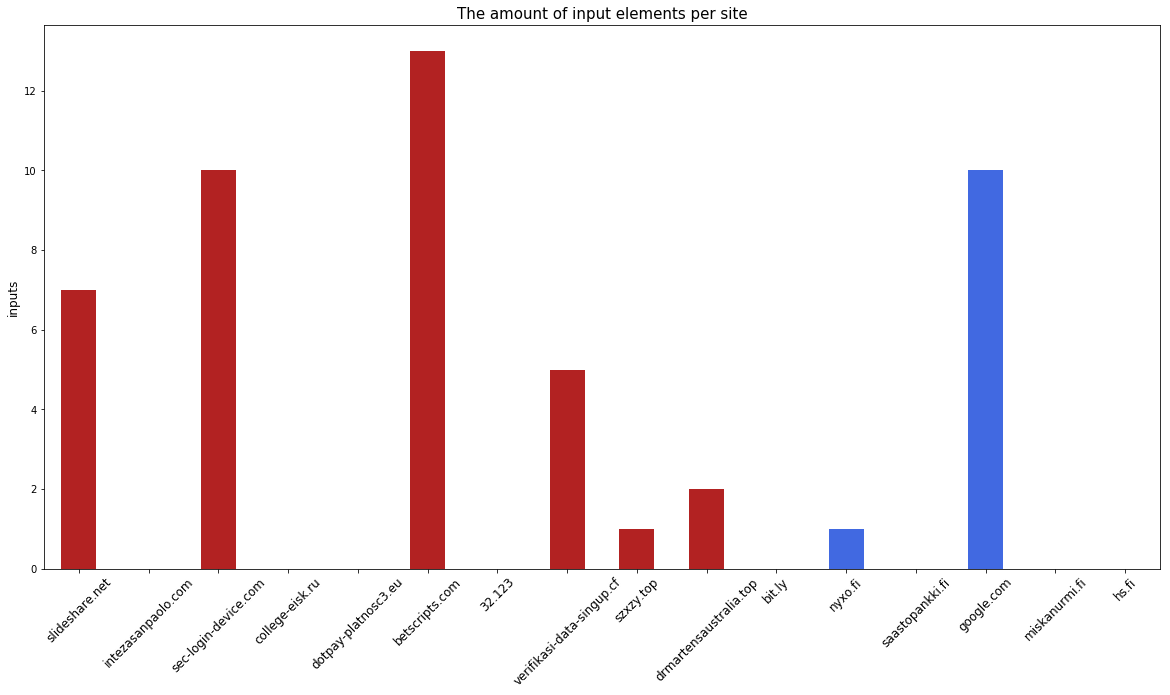

In [5]:
plt.figure(figsize=(20,10))

indexing = []
for url in example_urls:
    indexing.append(parse_domain_from_url(url))

phish_cites_n = 11
phish_c = phish_cites_n*['firebrick']

non_phish_n = 5
non_phish_c = non_phish_n*['royalblue']

c = phish_c + non_phish_c
    
df = pd.DataFrame(dataList, index=indexing)
df['Number of inputs'].plot(kind="bar", color=c)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("inputs", fontsize=12)
plt.title("The amount of input elements per site", fontsize=15)
plt.show()

From my extracted features I chose to visualize the amount of input field per site. The first eleven sites (in red, last one is "bit.ly") are from suspected phising sites while the last five (in blue) are from known valid sites. 

From this we can see that some of the phising sites contain input elements, but not all. This is somewhat surprising as phising sites usually need some form of input to do the phishing. By looking to the actual sites it becomes apparent that the phising sites that did not contain input fields were down or otherwise not responsive. The only phishing site that was active and did not contain inputs was the "bit.ly" site (which used redirects). 

From the visualization it seems that on average, phishing sites contain more input elements than legimate sites, though the sample is still quite small. On the other hand the amount of input fields in phishing sites varies a lot, when in legimate sites it seems to be that there are only a few (0 to 1) or a lot (10) of inputs. Though again, the sample is small.

It might be that in combination with other elements input amount might offer a descent feature to detect if a site might be phising or not, but even from this data it becomes clear that it's not 100% reliable as a single detection feature. However, it does seem to give indication that the site is either down or likely not phising.

### How to manage error handling, if one of the feature extractor fails

Currently the feature extractors have some basic error handling in place and the rest of the results can be used even if a single feature is not properly extracted. For instance, if age extraction is not properly extracted, we still have 8 other features that we can use for classification. 

However, if a feature extractor fails, there should be some indication that such an event has happened. Now it a feature extractor usually just returns "NaN", but we should also know why it couldn't be extracted (so we should know if the site was down or if the info extraction was somehow not possible for other reasons). To support this, it should be ensured that NaN values are in format that can be used by the chosen model during training. 